In [1]:
import os
import pandas as pd
import scanpy as sc
import anndata as ad
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gseapy as gp
from adjustText import adjust_text


In [2]:

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=300, facecolor="white")
sc.set_figure_params(fontsize=6)
sc.settings.vector_friendly = False

scanpy==1.10.3 anndata==0.10.9 umap==0.5.7 numpy==2.0.2 scipy==1.13.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


# DGE and GSEA 

## Load Data and Prep

In [3]:
#Load annotataed file
adata_new = sc.read_h5ad("Final_Notebooks/Final_Objects/PBMCs_anno_manual_refined_renamed.h5ad")
adata_new

AnnData object with n_obs × n_vars = 120853 × 1631
    obs: 'ExperimentID', 'ConditionID', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'Donor', 'Condition', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'predicted_doublet_0.2', 'predicted_doublet_0.25', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'Annotations_broad', 'Broad_Manual_Anno', 'Broad_Manual_Anno_renamed'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', '

In [4]:
adata_new = adata_new.raw.to_adata()

In [5]:
# Set 'Condition' as an ordered categorical based on its current unique values
adata_new.obs['Condition'] = pd.Categorical(
    adata_new.obs['Condition'],
    categories=np.array(adata_new.obs['Condition'].unique()), 
    ordered=True
)

# Sort the data by both 'Broad_Manual_Anno_renamed' and 'Condition'
indices = adata_new.obs.sort_values(['Broad_Manual_Anno_renamed', 'Condition']).index

# Reorder the AnnData object based on the sorted indices
adata_new = adata_new[indices, :]


## Subset for conditions of interest to perform DGE and GO term analysis on CD4+ Treg Cells

In [6]:
bdata = adata_new[adata_new.obs.Broad_Manual_Anno_renamed == "CD4+ Treg Cells"].copy()
bdata = bdata[bdata.obs.Condition.isin(["Control","PHA + CM4620"])].copy()

In [7]:
sc.pp.highly_variable_genes(bdata, min_mean=0.0125, min_disp=0.5)
bdata.raw = bdata
bdata = bdata[:, bdata.var.highly_variable]

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [8]:
# find degs
sc.tl.rank_genes_groups(bdata,
                        groupby='Condition',
                        method='wilcoxon',
                        groups=["PHA + CM4620"],
                        reference='Control')

ranking genes


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


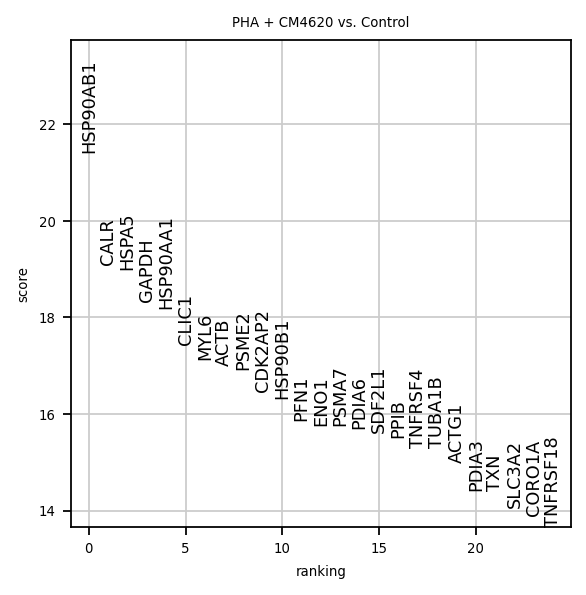

In [9]:
sc.pl.rank_genes_groups(bdata, n_genes=25, sharey=False)


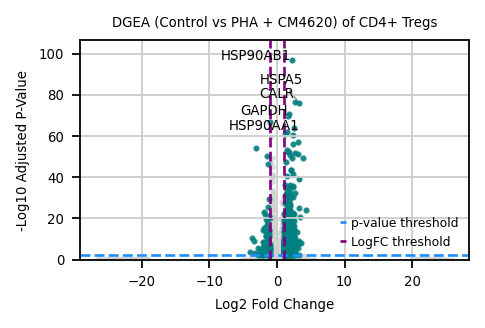

In [10]:
# Extracting the results
result = bdata.uns['rank_genes_groups']
groups = result['names'].dtype.names
genes = pd.DataFrame({group: result['names'][group] for group in groups}).stack().reset_index(level=0, drop=True)
logfold_changes = pd.DataFrame({group: result['logfoldchanges'][group] for group in groups}).stack().reset_index(level=0, drop=True)
pvals_adj = pd.DataFrame({group: result['pvals_adj'][group] for group in groups}).stack().reset_index(level=0, drop=True)

# Replace zero p-values with a small number for plotting
pvals_for_plotting = pvals_adj.copy()
pvals_for_plotting[pvals_for_plotting == 0] = 1e-300 

# Prepare data for plotting and saving
volcano_df = pd.DataFrame({
    'Gene': genes,
    'LogFC': logfold_changes,
    '-Log10P': -np.log10(pvals_for_plotting),
    'Adjusted_PValue': pvals_adj
})

# Define thresholds for highlighting
fc_threshold = 1
pval_threshold = 0.01
top_n = 5  # Number of top genes to label

# Determine upregulation/downregulation
volcano_df['Regulation'] = np.where(volcano_df['LogFC'] > fc_threshold, 'Upregulated',
                                    np.where(volcano_df['LogFC'] < -fc_threshold, 'Downregulated', 'Non-significant'))

# Plot
plt.figure(figsize=(3, 2))
# Plot non-significant genes
plt.scatter(volcano_df['LogFC'], volcano_df['-Log10P'], color='lightgray', alpha=0.7, s=3)

# Plot significant genes
significant = (np.abs(volcano_df['LogFC']) > fc_threshold) & (volcano_df['Adjusted_PValue'] < pval_threshold)
plt.scatter(volcano_df.loc[significant, 'LogFC'], volcano_df.loc[significant, '-Log10P'], color='teal', s=3, alpha=0.8)

# Annotate top genes by significance (p-value and fold change)
top_genes = volcano_df.loc[significant].sort_values(by=['-Log10P', 'LogFC'], ascending=[False, False]).head(top_n)

texts = []
for i, row in top_genes.iterrows():
    texts.append(plt.text(row['LogFC'], row['-Log10P'], row['Gene'], fontsize=6, ha='right', color='black'))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

# Threshold lines for fold change and p-value
plt.axhline(-np.log10(pval_threshold), color='dodgerblue', linestyle='--', linewidth=1.2, label='p-value threshold')
plt.axvline(fc_threshold, color='purple', linestyle='--', linewidth=1.2, label='LogFC threshold')
plt.axvline(-fc_threshold, color='purple', linestyle='--', linewidth=1.2)

# Customizing plot aesthetics
plt.xlabel('Log2 Fold Change', fontsize=6)
plt.ylabel('-Log10 Adjusted P-Value', fontsize=6)
plt.title('DGEA (Control vs PHA + CM4620) of CD4+ Tregs', fontsize=6)
plt.legend(loc='lower right', frameon=False)

# Customizing ticks and limits for cleaner look
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.ylim(0, volcano_df['-Log10P'].max() * 1.1)
plt.xlim(volcano_df['LogFC'].min() * 1.1, volcano_df['LogFC'].max() * 1.1)

plt.tight_layout()
plt.show()


In [11]:
# Save significant genes to CSV with adjusted p-value and regulation status
significant_genes_df = volcano_df.loc[significant].sort_values(by=['-Log10P', 'LogFC'], ascending=[False, False])
filename = 'Final_Notebooks/Figures/Drug_DGE/significant_genes_Control_vs_PHA_CM4620_CD4Treg.csv'
significant_genes_df[['Gene', 'LogFC', 'Adjusted_PValue', 'Regulation']].to_csv(filename, index=False)

In [12]:
# Retrieve DEGs from Scanpy's rank_genes_groups results
result = bdata.uns['rank_genes_groups']
groups = result['names'].dtype.names

# Convert results into a single DataFrame
degs = pd.DataFrame({
    f"{group}_{key}": result[key][group]
    for group in groups
    for key in ['names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges']
})

# Filter significant DEGs for PHA + CM4620
degs_sig = degs[degs["PHA + CM4620_pvals_adj"] < 0.01]
degs_up = degs_sig[degs_sig["PHA + CM4620_logfoldchanges"] > 1]
degs_dw = degs_sig[degs_sig["PHA + CM4620_logfoldchanges"] < -1]

# Run Enrichr on upregulated DEGs using a local GMT file
enr_up = gp.enrichr(
    gene_list=degs_up["PHA + CM4620_names"],
    gene_sets="Final_Notebooks/GSEA_files/c5.all.v2023.2.Hs.symbols.gmt",
    organism='human',
    outdir=None
)

# Clean up term names (remove prefix) and filter for specific immune terms
enr_up.res2d['Term'] = enr_up.res2d['Term'].apply(
    lambda x: '_'.join(x.split('_')[1:]) if len(x.split('_')) > 1 else None
)
enr_up.res2d = enr_up.res2d[
    (enr_up.res2d["Adjusted P-value"] < 0.05) &
    (enr_up.res2d['Term'].str.contains(r'TOLERANCE|REGULATION_OF_T_|CYTOTOX', na=False))
]

# Sort by significance
enr_up.res2d = enr_up.res2d.sort_values('Adjusted P-value', ascending=True)

# Get gene list from top enriched term
np.array(enr_up.res2d['Genes'][:1])


array(['TNFRSF1B;CORO1A;IL2RG;HSPH1;SIT1;TNFRSF9;LGALS1;PTPN6;LRRC32;HSPD1;XBP1;PRELID1;CD28;ACTL6A;ICOS;PNP;CTLA4;IL2RA;SELENOK;BATF;ACTB;SIRPG;PRNP;CD74;CBFB;RAC2'],
      dtype=object)

In [13]:
# Run Enrichr on downregulated DEGs using local GMT file
enr_dw = gp.enrichr(
    gene_list=degs_dw["PHA + CM4620_names"],
    gene_sets="Final_Notebooks/GSEA_files/c5.all.v2023.2.Hs.symbols.gmt",
    organism='human',
    outdir=None
)

# Clean up term names (remove GO category prefix like GO_REGULATION_OF_...)
enr_dw.res2d['Term'] = enr_dw.res2d['Term'].apply(
    lambda x: '_'.join(x.split('_')[1:]) if len(x.split('_')) > 1 else None
)

# Filter by significance
enr_dw.res2d = enr_dw.res2d[enr_dw.res2d["Adjusted P-value"] < 0.05]

# Keep only terms related to tolerance, T cell regulation, or cytotoxicity
enr_dw.res2d = enr_dw.res2d[
    enr_dw.res2d['Term'].str.contains(r'TOLERANCE|REGULATION_OF_T_|CYTOTOX', na=False)
]


In [14]:
# concat results
enr_up.res2d['UP_DW'] = "UP"
enr_dw.res2d['UP_DW'] = "DOWN"
enr_res = pd.concat([enr_up.res2d.head(9), enr_dw.res2d.head()])

/tmp/ipykernel_3861101/507156283.py:29: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


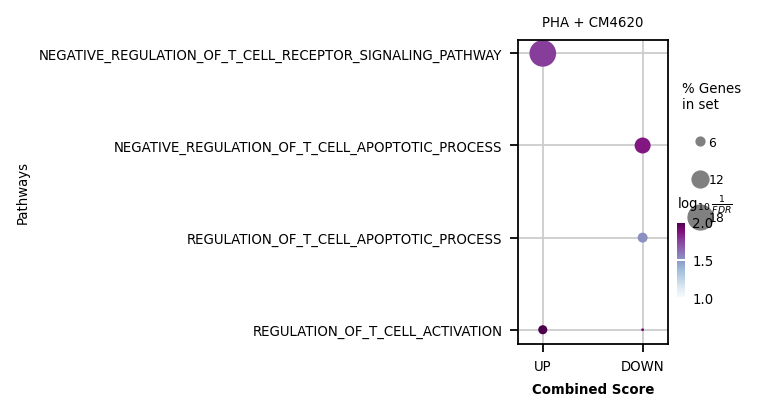

In [15]:
# Define order of key T cell regulatory pathways
order = [
    'NEGATIVE_REGULATION_OF_T_CELL_PROLIFERATION',
    'T_CELL_TOLERANCE_INDUCTION',
    'REGULATION_OF_T_CELL_MEDIATED_IMMUNE_RESPONSE_TO_TUMOR_CELL',
    'REGULATION_OF_T_CELL_ACTIVATION'
]

# Generate dotplot with gseapy
ax = gp.dotplot(
    enr_res,
    figsize=(1.5, 2.5),
    x='UP_DW',                    # Column with UP/DOWN label
    x_order=["UP", "DOWN"],
    title="GO_BP",
    cmap='BuPu',
    size=10,
    y_order=order,
    show_ring=False
)

# Customize axes and labels
ax.set_title("PHA + CM4620", fontsize=6)
ax.set_xlabel("Combined Score", fontsize=6)
ax.set_ylabel("Pathways", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)

# Save and show plot
plt.tight_layout()
plt.savefig('Final_Notebooks/Figures/Drug_DGE/CM4620_dot_plot_comb.pdf', bbox_inches='tight', dpi=300)
plt.show()


## For stimulated BTP2 treated cells vs Control

In [16]:
bdata = adata_new[adata_new.obs.Broad_Manual_Anno_renamed == "CD4+ Treg Cells"].copy()
bdata = bdata[bdata.obs.Condition.isin(["Control","PHA + BTP2"])].copy()
bdata

AnnData object with n_obs × n_vars = 957 × 16537
    obs: 'ExperimentID', 'ConditionID', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'Donor', 'Condition', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'predicted_doublet_0.2', 'predicted_doublet_0.25', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'Annotations_broad', 'Broad_Manual_Anno', 'Broad_Manual_Anno_renamed'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'hi

In [17]:
sc.pp.highly_variable_genes(bdata, min_mean=0.0125, min_disp=0.5)
bdata.raw = bdata
bdata = bdata[:, bdata.var.highly_variable]

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [18]:
sc.tl.rank_genes_groups(bdata,
                        groupby='Condition',
                        method='wilcoxon',
                        groups=["PHA + BTP2"],
                        reference='Control')

ranking genes


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


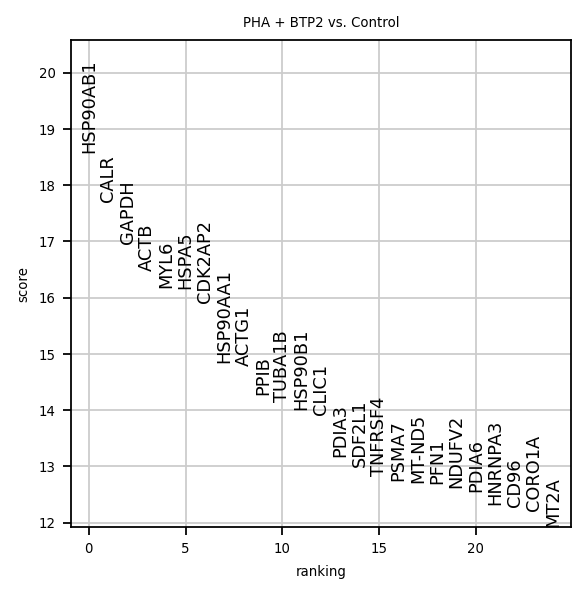

In [19]:
sc.pl.rank_genes_groups(bdata, n_genes=25, sharey=False)


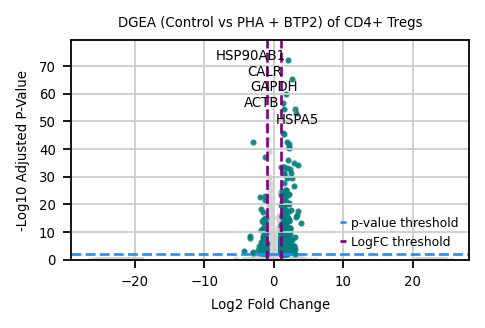

In [20]:
# Extracting the results
result = bdata.uns['rank_genes_groups']
groups = result['names'].dtype.names
genes = pd.DataFrame({group: result['names'][group] for group in groups}).stack().reset_index(level=0, drop=True)
logfold_changes = pd.DataFrame({group: result['logfoldchanges'][group] for group in groups}).stack().reset_index(level=0, drop=True)
pvals_adj = pd.DataFrame({group: result['pvals_adj'][group] for group in groups}).stack().reset_index(level=0, drop=True)

# Replace zero p-values with a small number for plotting
pvals_for_plotting = pvals_adj.copy()
pvals_for_plotting[pvals_for_plotting == 0] = 1e-300 

# Prepare data for plotting and saving
volcano_df = pd.DataFrame({
    'Gene': genes,
    'LogFC': logfold_changes,
    '-Log10P': -np.log10(pvals_for_plotting),
    'Adjusted_PValue': pvals_adj
})

# Define thresholds for highlighting
fc_threshold = 1
pval_threshold = 0.01
top_n = 5  # Number of top genes to label

# Determine upregulation/downregulation
volcano_df['Regulation'] = np.where(volcano_df['LogFC'] > fc_threshold, 'Upregulated',
                                    np.where(volcano_df['LogFC'] < -fc_threshold, 'Downregulated', 'Non-significant'))

# Plot
plt.figure(figsize=(3, 2))
# Plot non-significant genes
plt.scatter(volcano_df['LogFC'], volcano_df['-Log10P'], color='lightgray', alpha=0.7, s=3)

# Plot significant genes
significant = (np.abs(volcano_df['LogFC']) > fc_threshold) & (volcano_df['Adjusted_PValue'] < pval_threshold)
plt.scatter(volcano_df.loc[significant, 'LogFC'], volcano_df.loc[significant, '-Log10P'], color='teal', s=3, alpha=0.8)

# Annotate top genes by significance (p-value and fold change)
top_genes = volcano_df.loc[significant].sort_values(by=['-Log10P', 'LogFC'], ascending=[False, False]).head(top_n)

texts = []
for i, row in top_genes.iterrows():
    texts.append(plt.text(row['LogFC'], row['-Log10P'], row['Gene'], fontsize=6, ha='right', color='black'))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

# Threshold lines for fold change and p-value
plt.axhline(-np.log10(pval_threshold), color='dodgerblue', linestyle='--', linewidth=1.2, label='p-value threshold')
plt.axvline(fc_threshold, color='purple', linestyle='--', linewidth=1.2, label='LogFC threshold')
plt.axvline(-fc_threshold, color='purple', linestyle='--', linewidth=1.2)

# Customizing plot aesthetics
plt.xlabel('Log2 Fold Change', fontsize=6)
plt.ylabel('-Log10 Adjusted P-Value', fontsize=6)
plt.title('DGEA (Control vs PHA + BTP2) of CD4+ Tregs', fontsize=6)
plt.legend(loc='lower right', frameon=False)

# Customizing ticks and limits for cleaner look
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.ylim(0, volcano_df['-Log10P'].max() * 1.1)
plt.xlim(volcano_df['LogFC'].min() * 1.1, volcano_df['LogFC'].max() * 1.1)

plt.tight_layout()
#plt.savefig('Final_Notebooks/Figures/Drug_DGE/PHA_BTP2_volcano_plot_CD4_Tregs.pdf', bbox_inches='tight',dpi=300)
plt.show()


In [21]:
# Save significant genes to CSV with adjusted p-value and regulation status
significant_genes_df = volcano_df.loc[significant].sort_values(by=['-Log10P', 'LogFC'], ascending=[False, False])
filename = 'Final_Notebooks/Figures/Drug_DGE/significant_genes_Control_vs_PHA_BTP2_CD4Treg.csv'
significant_genes_df[['Gene', 'LogFC', 'Adjusted_PValue', 'Regulation']].to_csv(filename, index=False)


In [22]:
# Extract DEGs from Scanpy results
result = bdata.uns['rank_genes_groups']
groups = result['names'].dtype.names

# Build a long-form DEG DataFrame
degs = pd.DataFrame({
    f"{group}_{key}": result[key][group]
    for group in groups
    for key in ['names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges']
})

# Subset for significantly up/down-regulated genes in "PHA + BTP2"
degs_sig = degs[degs["PHA + BTP2_pvals_adj"] < 0.01]
degs_up = degs_sig[degs_sig["PHA + BTP2_logfoldchanges"] > 1]
degs_dw = degs_sig[degs_sig["PHA + BTP2_logfoldchanges"] < -1]

# Run Enrichr on upregulated genes
enr_up = gp.enrichr(
    gene_list=degs_up["PHA + BTP2_names"],
    gene_sets="Final_Notebooks/GSEA_files/c5.all.v2023.2.Hs.symbols.gmt",
    organism='human',
    outdir=None
)

# Clean up term names and filter for relevant immune-related categories
enr_up.res2d['Term'] = enr_up.res2d['Term'].apply(
    lambda x: '_'.join(x.split('_')[1:]) if len(x.split('_')) > 1 else x
)
enr_up.res2d = enr_up.res2d[
    (enr_up.res2d["Adjusted P-value"] < 0.05) &
    (enr_up.res2d['Term'].str.contains(r'TOLERANCE|REGULATION_OF_T_|CYTOTOX', na=False))
]

# Sort by significance
enr_up.res2d = enr_up.res2d.sort_values('Adjusted P-value')

# Output the first hit's genes
np.array(enr_up.res2d['Genes'][:1])


array(['CORO1A;IL2RG;HSPH1;SOCS1;TNFRSF9;LGALS1;PTPN6;LRRC32;HSPD1;XBP1;PRELID1;CD28;PNP;CTLA4;TIGIT;SELENOK;BATF;ACTB;PRNP;RAC2'],
      dtype=object)

In [23]:
# Run Enrichr on downregulated genes from "PHA + BTP2"
enr_dw = gp.enrichr(
    gene_list=degs_dw["PHA + BTP2_names"],
    gene_sets="Final_Notebooks/GSEA_files/c5.all.v2023.2.Hs.symbols.gmt",
    organism='human',
    outdir=None
)

# Remove GO term prefixes (e.g., GO_REGULATION_OF_T_CELL...)
enr_dw.res2d['Term'] = enr_dw.res2d['Term'].apply(
    lambda x: '_'.join(x.split('_')[1:]) if len(x.split('_')) > 1 else None
)

# Filter for significant pathways
enr_dw.res2d = enr_dw.res2d[enr_dw.res2d["Adjusted P-value"] < 0.05]

# Keep only immune regulation / cytotoxicity / tolerance related terms
enr_dw.res2d = enr_dw.res2d[
    enr_dw.res2d['Term'].str.contains(r'TOLERANCE_|REGULATION_OF_T_|CYTOTOX', na=False)
]


In [24]:
# concat results
enr_up.res2d['UP_DW'] = "UP"
enr_dw.res2d['UP_DW'] = "DOWN"
enr_res = pd.concat([enr_up.res2d.head(9), enr_dw.res2d.head()])

/tmp/ipykernel_3861101/1386146162.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


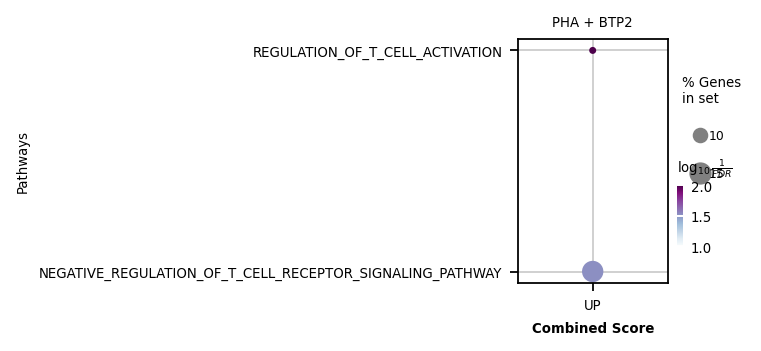

In [25]:
# Plot GO enrichment dotplot for PHA + BTP2 (UP vs DOWN regulated)
ax = gp.dotplot(
    enr_res,                      # DataFrame with enrichment results and 'UP_DW' column
    figsize=(1.5, 2),
    x='UP_DW',                    # Column defining Up vs Down regulation
    x_order=["UP", "DOWN"],       # Ensure fixed column order
    title="GO_BP",
    cmap='BuPu',                  # Purple-to-blue color scale
    size=10,
    show_ring=False,              # No donut rings
    vmin=0                        # Lower bound of color scale
)

# Customize axis titles
ax.set_title("PHA + BTP2", fontsize=6)
ax.set_xlabel("Combined Score", fontsize=6)
ax.set_ylabel("Pathways", fontsize=6)

# Adjust tick size
ax.tick_params(axis='both', which='major', labelsize=6)

# Layout and save
plt.tight_layout()
plt.savefig('Final_Notebooks/Figures/Drug_DGE/BTP2_dot_plot_comb.pdf', bbox_inches='tight', dpi=300)
plt.show()


/tmp/ipykernel_3861101/1878626881.py:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


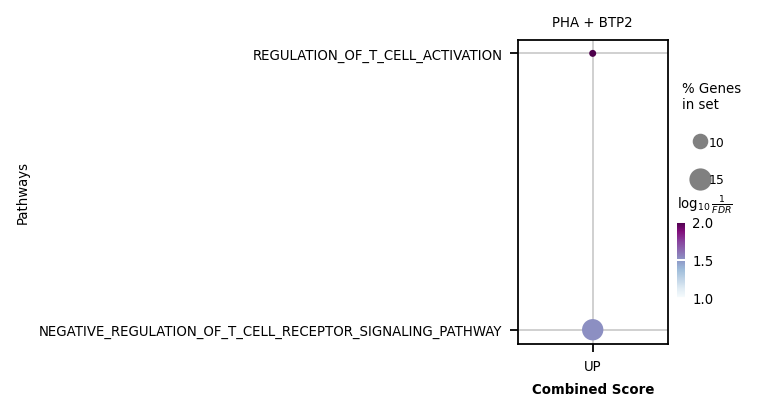

In [26]:
ax = gp.dotplot(enr_res,figsize=(1.5,2.5),
                x='UP_DW',
                x_order = ["UP","DOWN"],
                title="GO_BP",
                cmap = 'BuPu',
                size=10,
                show_ring=False,vmin=0)

ax.set_title("PHA + BTP2", fontsize=6)

ax.set_xlabel("Combined Score", fontsize=6)  
ax.set_ylabel("Pathways", fontsize=6)    

ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()

plt.savefig('Final_Notebooks/Figures/Drug_DGE/BTP2_dot_plot_comb_scale.pdf', bbox_inches='tight',dpi=300)
plt.show()

## Cytotoxicity in PHA vs Control in CD8+ Effector T cells

In [27]:
bdata = adata_new[adata_new.obs.Broad_Manual_Anno_renamed.isin(["CD8+ Effector T Cells"])].copy()
bdata = bdata[bdata.obs.Condition.isin(["Control","PHA"])].copy()
bdata

AnnData object with n_obs × n_vars = 5207 × 16537
    obs: 'ExperimentID', 'ConditionID', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'Donor', 'Condition', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'predicted_doublet_0.2', 'predicted_doublet_0.25', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'Annotations_broad', 'Broad_Manual_Anno', 'Broad_Manual_Anno_renamed'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'h

In [28]:
sc.pp.highly_variable_genes(bdata, min_mean=0.025, min_disp=0.5)
bdata.raw = bdata
bdata = bdata[:, bdata.var.highly_variable]

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [29]:
# find degs
#bdata.layers['lognorm'] = bdata.X
sc.tl.rank_genes_groups(bdata,
                        groupby='Condition',
                        #use_raw=False,
                        #layer='lognorm',
                        method='wilcoxon',
                        groups=["PHA"],
                        reference='Control')

ranking genes


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


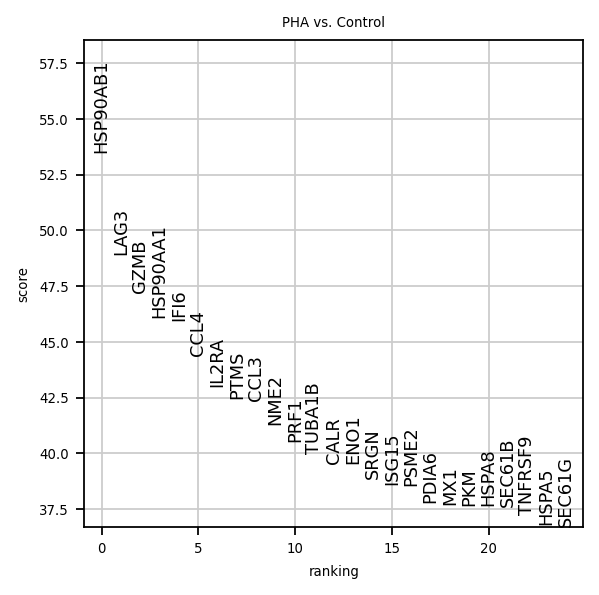

In [30]:
sc.pl.rank_genes_groups(bdata, n_genes=25, sharey=False)


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


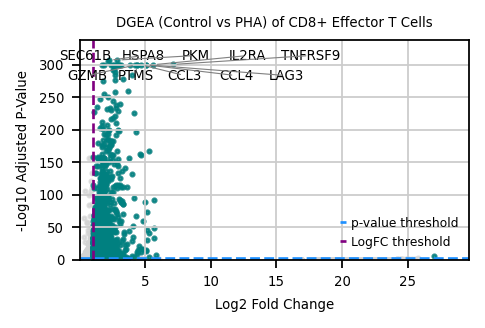

In [31]:
# Extracting the results
result = bdata.uns['rank_genes_groups']
groups = result['names'].dtype.names
genes = pd.DataFrame({group: result['names'][group] for group in groups}).stack().reset_index(level=0, drop=True)
logfold_changes = pd.DataFrame({group: result['logfoldchanges'][group] for group in groups}).stack().reset_index(level=0, drop=True)
pvals_adj = pd.DataFrame({group: result['pvals_adj'][group] for group in groups}).stack().reset_index(level=0, drop=True)

# Replace zero p-values with a small number for plotting
pvals_for_plotting = pvals_adj.copy()
pvals_for_plotting[pvals_for_plotting == 0] = 1e-300 

# Prepare data for plotting and saving
volcano_df = pd.DataFrame({
    'Gene': genes,
    'LogFC': logfold_changes,
    '-Log10P': -np.log10(pvals_for_plotting),
    'Adjusted_PValue': pvals_adj
})

# Define thresholds for highlighting
fc_threshold = 1
pval_threshold = 0.01
top_n = 10  # Number of top genes to label

# Determine upregulation/downregulation
volcano_df['Regulation'] = np.where(volcano_df['LogFC'] > fc_threshold, 'Upregulated',
                                    np.where(volcano_df['LogFC'] < -fc_threshold, 'Downregulated', 'Non-significant'))

volcano_df = volcano_df[volcano_df['LogFC']>0]
# Plot
plt.figure(figsize=(3, 2))
# Plot non-significant genes
plt.scatter(volcano_df['LogFC'], volcano_df['-Log10P'], color='lightgray', alpha=0.7, s=3)

# Plot significant genes
significant = (np.abs(volcano_df['LogFC']) > fc_threshold) & (volcano_df['Adjusted_PValue'] < pval_threshold)
plt.scatter(volcano_df.loc[significant, 'LogFC'], volcano_df.loc[significant, '-Log10P'], color='teal', s=3, alpha=0.8)

# Annotate top genes by significance (p-value and fold change)
top_genes = volcano_df.loc[significant].sort_values(by=['-Log10P', 'LogFC'], ascending=[False, False]).head(top_n)

texts = []
for i, row in top_genes.iterrows():
    texts.append(plt.text(row['LogFC'], row['-Log10P'], row['Gene'], fontsize=6, ha='right', color='black'))

# Adjust text to avoid overlap
adjust_text(texts,
            arrowprops=dict(arrowstyle="-", color='gray', lw=0.5),
            expand_text=(4.0, 4.0),
            expand_points=(4.0, 4.0),
            force_text=2.0,
            force_points=2.0)

# Threshold lines for fold change and p-value
plt.axhline(-np.log10(pval_threshold), color='dodgerblue', linestyle='--', linewidth=1.2, label='p-value threshold')
plt.axvline(fc_threshold, color='purple', linestyle='--', linewidth=1.2, label='LogFC threshold')
plt.axvline(-fc_threshold, color='purple', linestyle='--', linewidth=1.2)

# Customizing plot aesthetics
plt.xlabel('Log2 Fold Change', fontsize=6)
plt.ylabel('-Log10 Adjusted P-Value', fontsize=6)
plt.title('DGEA (Control vs PHA) of CD8+ Effector T Cells', fontsize=6)
plt.legend(loc='lower right', frameon=False)

# Customizing ticks and limits for cleaner look
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.ylim(0, volcano_df['-Log10P'].max() * 1.1)
plt.xlim(volcano_df['LogFC'].min() * 1.1, volcano_df['LogFC'].max() * 1.1)

plt.tight_layout()
plt.savefig('Final_Notebooks/Figures/Drug_DGE/PHA_volcano_plot_CD8_Effector.pdf', bbox_inches='tight',dpi=300)
plt.show()


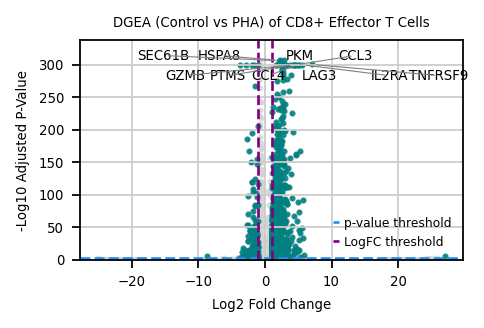

In [32]:
# Extracting the results
result = bdata.uns['rank_genes_groups']
groups = result['names'].dtype.names
genes = pd.DataFrame({group: result['names'][group] for group in groups}).stack().reset_index(level=0, drop=True)
logfold_changes = pd.DataFrame({group: result['logfoldchanges'][group] for group in groups}).stack().reset_index(level=0, drop=True)
pvals_adj = pd.DataFrame({group: result['pvals_adj'][group] for group in groups}).stack().reset_index(level=0, drop=True)

# Replace zero p-values with a small number for plotting
pvals_for_plotting = pvals_adj.copy()
pvals_for_plotting[pvals_for_plotting == 0] = 1e-300 

# Prepare data for plotting and saving
volcano_df = pd.DataFrame({
    'Gene': genes,
    'LogFC': logfold_changes,
    '-Log10P': -np.log10(pvals_for_plotting),
    'Adjusted_PValue': pvals_adj
})

# Define thresholds for highlighting
fc_threshold = 1
pval_threshold = 0.01
top_n = 10  # Number of top genes to label

# Determine upregulation/downregulation
volcano_df['Regulation'] = np.where(volcano_df['LogFC'] > fc_threshold, 'Upregulated',
                                    np.where(volcano_df['LogFC'] < -fc_threshold, 'Downregulated', 'Non-significant'))

# Plot
plt.figure(figsize=(3, 2))
# Plot non-significant genes
plt.scatter(volcano_df['LogFC'], volcano_df['-Log10P'], color='lightgray', alpha=0.7, s=3)

# Plot significant genes
significant = (np.abs(volcano_df['LogFC']) > fc_threshold) & (volcano_df['Adjusted_PValue'] < pval_threshold)
plt.scatter(volcano_df.loc[significant, 'LogFC'], volcano_df.loc[significant, '-Log10P'], color='teal', s=3, alpha=0.8)

# Annotate top genes by significance (p-value and fold change)
top_genes = volcano_df.loc[significant].sort_values(by=['-Log10P', 'LogFC'], ascending=[False, False]).head(top_n)

texts = []
for i, row in top_genes.iterrows():
    texts.append(plt.text(row['LogFC'], row['-Log10P'], row['Gene'], fontsize=6, ha='right', color='black'))

# Adjust text to avoid overlap
adjust_text(texts,
            arrowprops=dict(arrowstyle="-", color='gray', lw=0.5),
            expand_text=(4.0, 4.0),
            expand_points=(4.0, 4.0),
            force_text=2.0,
            force_points=2.0)

# Threshold lines for fold change and p-value
plt.axhline(-np.log10(pval_threshold), color='dodgerblue', linestyle='--', linewidth=1.2, label='p-value threshold')
plt.axvline(fc_threshold, color='purple', linestyle='--', linewidth=1.2, label='LogFC threshold')
plt.axvline(-fc_threshold, color='purple', linestyle='--', linewidth=1.2)

# Customizing plot aesthetics
plt.xlabel('Log2 Fold Change', fontsize=6)
plt.ylabel('-Log10 Adjusted P-Value', fontsize=6)
plt.title('DGEA (Control vs PHA) of CD8+ Effector T Cells', fontsize=6)
plt.legend(loc='lower right', frameon=False)

# Customizing ticks and limits for cleaner look
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.ylim(0, volcano_df['-Log10P'].max() * 1.1)
plt.xlim(volcano_df['LogFC'].min() * 1.1, volcano_df['LogFC'].max() * 1.1)

plt.tight_layout()
plt.show()


In [33]:
# Save significant genes to CSV with adjusted p-value and regulation status
significant_genes_df = volcano_df.loc[significant].sort_values(by=['-Log10P', 'LogFC'], ascending=[False, False])
filename = 'Final_Notebooks/Figures/Drug_DGE/significant_genes_Control_vs_PHA_CD8T.csv'
significant_genes_df[['Gene', 'LogFC', 'Adjusted_PValue', 'Regulation']].to_csv(filename, index=False)


In [34]:
fc_threshold = 1  # Fold change threshold
pval_threshold = 0.01  # Adjusted p-value threshold

# Apply thresholds to identify upregulated and downregulated genes
upregulated = volcano_df[(volcano_df['LogFC'] > fc_threshold) & (volcano_df['-Log10P'] > -np.log10(pval_threshold))]
downregulated = volcano_df[(volcano_df['LogFC'] < -fc_threshold) & (volcano_df['-Log10P'] > -np.log10(pval_threshold))]

# Count upregulated and downregulated genes
num_upregulated = upregulated.shape[0]
num_downregulated = downregulated.shape[0]

# Print the results
print(f"Number of upregulated genes: {num_upregulated}")
print(f"Number of downregulated genes: {num_downregulated}")

Number of upregulated genes: 1752
Number of downregulated genes: 188


In [35]:
# get deg result
result = bdata.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})

In [36]:
degs.head()


,PHA_names,PHA_scores,PHA_pvals,PHA_pvals_adj,PHA_logfoldchanges
0,HSP90AB1,53.494991,0.0,0.0,3.161348
1,LAG3,48.901489,0.0,0.0,5.054995
2,GZMB,47.218262,0.0,0.0,4.333217
3,HSP90AA1,46.060806,0.0,0.0,1.860810
4,IFI6,45.945141,0.0,0.0,4.203979


In [37]:
# subset up or down regulated genes
degs_sig = degs[degs["PHA_pvals_adj"] < 0.01]
degs_up = degs_sig[degs_sig["PHA_logfoldchanges"] > 1]
degs_dw = degs_sig[degs_sig["PHA_logfoldchanges"] < -1]

# Enricr API
enr_up = gp.enrichr(degs_up["PHA_names"],
                    gene_sets="Final_Notebooks/GSEA_files/c5.all.v2023.2.Hs.symbols.gmt",
                    organism='human',
                    outdir=None)

enr_up.res2d['Term'] = enr_up.res2d['Term'].apply(lambda x: '_'.join(x.split('_')[1:]) if len(x.split('_')) > 1 else None)


enr_up.res2d = enr_up.res2d[enr_up.res2d["Adjusted P-value"]<0.05]

enr_up.res2d = enr_up.res2d[enr_up.res2d['Term'].str.contains(r'_TOLERANCE_|CYTOTOX', na=False)]


In [38]:
enr_dw = gp.enrichr(degs_dw["PHA_names"],
                    gene_sets="Final_Notebooks/GSEA_files/c5.all.v2023.2.Hs.symbols.gmt",
                    organism='human',
                    outdir=None)

enr_dw.res2d['Term'] = enr_dw.res2d['Term'].apply(lambda x: '_'.join(x.split('_')[1:]) if len(x.split('_')) > 1 else None)


enr_dw.res2d = enr_dw.res2d[enr_dw.res2d["Adjusted P-value"]<0.05]

enr_dw.res2d = enr_dw.res2d[enr_dw.res2d['Term'].str.contains(r'_TOLERANCE_|REGULATION_OF_T_CELL|CYTOTOX', na=False)]

In [39]:
enr_dw.res2d

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes


In [40]:
# concat results
enr_up.res2d['UP_DW'] = "UP"
enr_dw.res2d['UP_DW'] = "DOWN"
enr_res = pd.concat([enr_up.res2d.head(9), enr_dw.res2d.head()])

/tmp/ipykernel_3861101/731777891.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


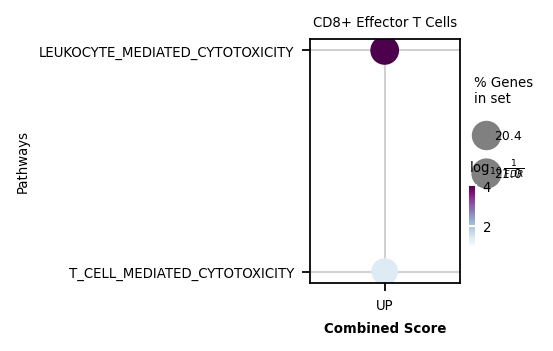

In [41]:
# display multi-dataset
ax = gp.dotplot(enr_res,figsize=(1.5,2),
                x='UP_DW',
                x_order = ["UP","DOWN"],
                title="GO_BP",
                cmap = 'BuPu',
                size=10,
                show_ring=False,vmin=0)

ax.set_title("CD8+ Effector T Cells", fontsize=6)

ax.set_xlabel("Combined Score", fontsize=6)  
ax.set_ylabel("Pathways", fontsize=6)    

ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()

plt.savefig('Final_Notebooks/Figures/Drug_DGE/PHA_dot_plot_comb_CD8_Effector.pdf', bbox_inches='tight',dpi=300)
plt.show()

/tmp/ipykernel_3861101/3552933333.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


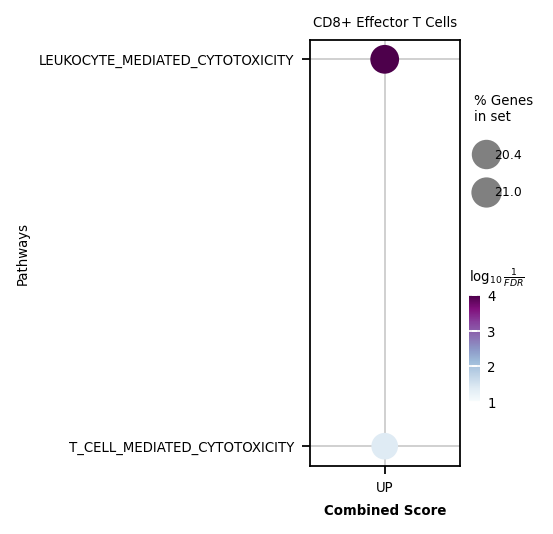

In [42]:
# display multi-dataset
ax = gp.dotplot(enr_res,figsize=(1.5,3.5),
                x='UP_DW',
                x_order = ["UP","DOWN"],
                title="GO_BP",
                cmap = 'BuPu',
                size=10,
                show_ring=False,vmin=0)

ax.set_title("CD8+ Effector T Cells", fontsize=6)

ax.set_xlabel("Combined Score", fontsize=6)  
ax.set_ylabel("Pathways", fontsize=6)    

ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig('Final_Notebooks/Figures/Drug_DGE/PHA_dot_plot_comb_CD8_Effector_scale.pdf', bbox_inches='tight',dpi=300)
plt.show()

## Cytotoxicity in PHA vs Control in NK Cells

In [43]:
bdata = adata_new[adata_new.obs.Broad_Manual_Anno_renamed.isin(["NK Cells"])].copy()
bdata = bdata[bdata.obs.Condition.isin(["Control","PHA"])].copy()
bdata

AnnData object with n_obs × n_vars = 4638 × 16537
    obs: 'ExperimentID', 'ConditionID', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'Donor', 'Condition', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'predicted_doublet_0.2', 'predicted_doublet_0.25', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'Annotations_broad', 'Broad_Manual_Anno', 'Broad_Manual_Anno_renamed'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'h

In [44]:
sc.pp.highly_variable_genes(bdata, min_mean=0.025, min_disp=0.5)
bdata.raw = bdata
bdata = bdata[:, bdata.var.highly_variable]

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [45]:
sc.tl.rank_genes_groups(bdata,
                        groupby='Condition',
                        method='wilcoxon',
                        groups=["PHA"],
                        reference='Control')

ranking genes


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


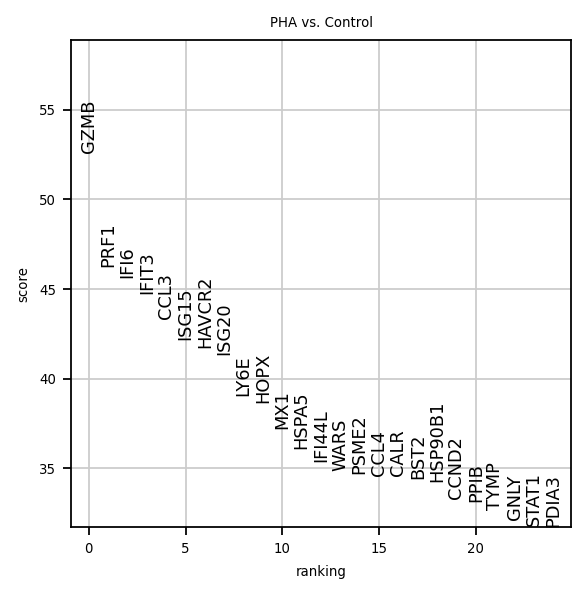

In [46]:
sc.pl.rank_genes_groups(bdata, n_genes=25, sharey=False)


5 [-0.47043419  0.8891048 ]
6 [-0.78526754  0.42801993]
5 [-0.08551903 -0.25738407]
6 [0.35868988 0.68117666]
4 [-0.60135441 -0.15331649]
5 [0.77883163 0.28065585]
5 [0.50107025 0.39232594]
6 [-0.02560384  0.86223776]


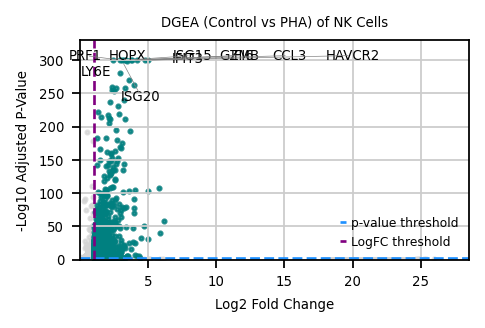

In [47]:
# Extracting the results
result = bdata.uns['rank_genes_groups']
groups = result['names'].dtype.names
genes = pd.DataFrame({group: result['names'][group] for group in groups}).stack().reset_index(level=0, drop=True)
logfold_changes = pd.DataFrame({group: result['logfoldchanges'][group] for group in groups}).stack().reset_index(level=0, drop=True)
pvals_adj = pd.DataFrame({group: result['pvals_adj'][group] for group in groups}).stack().reset_index(level=0, drop=True)

# Replace zero p-values with a small number for plotting
pvals_for_plotting = pvals_adj.copy()
pvals_for_plotting[pvals_for_plotting == 0] = 1e-300 

# Prepare data for plotting and saving
volcano_df = pd.DataFrame({
    'Gene': genes,
    'LogFC': logfold_changes,
    '-Log10P': -np.log10(pvals_for_plotting),
    'Adjusted_PValue': pvals_adj
})

# Define thresholds for highlighting
fc_threshold = 1
pval_threshold = 0.01
top_n = 10  # Number of top genes to label

# Determine upregulation/downregulation
volcano_df['Regulation'] = np.where(volcano_df['LogFC'] > fc_threshold, 'Upregulated',
                                    np.where(volcano_df['LogFC'] < -fc_threshold, 'Downregulated', 'Non-significant'))

volcano_df = volcano_df[volcano_df['LogFC']>0]
# Plot
plt.figure(figsize=(3, 2))
# Plot non-significant genes
plt.scatter(volcano_df['LogFC'], volcano_df['-Log10P'], color='lightgray', alpha=0.7, s=3)

# Plot significant genes
significant = (np.abs(volcano_df['LogFC']) > fc_threshold) & (volcano_df['Adjusted_PValue'] < pval_threshold)
plt.scatter(volcano_df.loc[significant, 'LogFC'], volcano_df.loc[significant, '-Log10P'], color='teal', s=3, alpha=0.8)

# Annotate top genes by significance (p-value and fold change)
top_genes = volcano_df.loc[significant].sort_values(by=['-Log10P', 'LogFC'], ascending=[False, False]).head(top_n)

texts = []
for i, row in top_genes.iterrows():
    texts.append(plt.text(row['LogFC'], row['-Log10P'], row['Gene'], fontsize=6, ha='right', color='black'))

# Adjust text to avoid overlap
adjust_text(texts,
            arrowprops=dict(arrowstyle="-", color='gray', lw=0.3),
            expand_text=(2.0, 2.0),
            expand_points=(2.0, 2.0),
            force_text=1.0,
            force_points=1.0)

# Threshold lines for fold change and p-value
plt.axhline(-np.log10(pval_threshold), color='dodgerblue', linestyle='--', linewidth=1.2, label='p-value threshold')
plt.axvline(fc_threshold, color='purple', linestyle='--', linewidth=1.2, label='LogFC threshold')
plt.axvline(-fc_threshold, color='purple', linestyle='--', linewidth=1.2)

# Customizing plot aesthetics
plt.xlabel('Log2 Fold Change', fontsize=6)
plt.ylabel('-Log10 Adjusted P-Value', fontsize=6)
plt.title('DGEA (Control vs PHA) of NK Cells', fontsize=6)
plt.legend(loc='lower right', frameon=False)

# Customizing ticks and limits for cleaner look
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.ylim(0, volcano_df['-Log10P'].max() * 1.1)
plt.xlim(volcano_df['LogFC'].min(), volcano_df['LogFC'].max() * 1.1)

plt.tight_layout()
plt.savefig('Final_Notebooks/Figures/Drug_DGE/PHA_volcano_plot_NK.pdf', bbox_inches='tight',dpi=300)
plt.show()


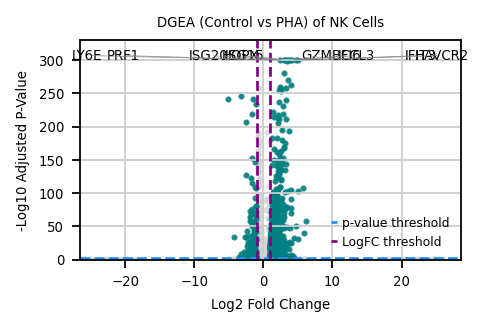

In [48]:
# Extracting the results
result = bdata.uns['rank_genes_groups']
groups = result['names'].dtype.names
genes = pd.DataFrame({group: result['names'][group] for group in groups}).stack().reset_index(level=0, drop=True)
logfold_changes = pd.DataFrame({group: result['logfoldchanges'][group] for group in groups}).stack().reset_index(level=0, drop=True)
pvals_adj = pd.DataFrame({group: result['pvals_adj'][group] for group in groups}).stack().reset_index(level=0, drop=True)

# Replace zero p-values with a small number for plotting
pvals_for_plotting = pvals_adj.copy()
pvals_for_plotting[pvals_for_plotting == 0] = 1e-300 

# Prepare data for plotting and saving
volcano_df = pd.DataFrame({
    'Gene': genes,
    'LogFC': logfold_changes,
    '-Log10P': -np.log10(pvals_for_plotting),
    'Adjusted_PValue': pvals_adj
})

# Define thresholds for highlighting
fc_threshold = 1
pval_threshold = 0.01
top_n = 10  # Number of top genes to label

# Determine upregulation/downregulation
volcano_df['Regulation'] = np.where(volcano_df['LogFC'] > fc_threshold, 'Upregulated',
                                    np.where(volcano_df['LogFC'] < -fc_threshold, 'Downregulated', 'Non-significant'))

# Plot
plt.figure(figsize=(3, 2))
# Plot non-significant genes
plt.scatter(volcano_df['LogFC'], volcano_df['-Log10P'], color='lightgray', alpha=0.7, s=3)

# Plot significant genes
significant = (np.abs(volcano_df['LogFC']) > fc_threshold) & (volcano_df['Adjusted_PValue'] < pval_threshold)
plt.scatter(volcano_df.loc[significant, 'LogFC'], volcano_df.loc[significant, '-Log10P'], color='teal', s=3, alpha=0.8)

# Annotate top genes by significance (p-value and fold change)
top_genes = volcano_df.loc[significant].sort_values(by=['-Log10P', 'LogFC'], ascending=[False, False]).head(top_n)

texts = []
for i, row in top_genes.iterrows():
    texts.append(plt.text(row['LogFC'], row['-Log10P'], row['Gene'], fontsize=6, ha='right', color='black'))

# Adjust text to avoid overlap
adjust_text(texts,
            arrowprops=dict(arrowstyle="-", color='gray', lw=0.3),
            expand_text=(2.0, 2.0),
            expand_points=(2.0, 2.0),
            force_text=1.0,
            force_points=1.0)

# Threshold lines for fold change and p-value
plt.axhline(-np.log10(pval_threshold), color='dodgerblue', linestyle='--', linewidth=1.2, label='p-value threshold')
plt.axvline(fc_threshold, color='purple', linestyle='--', linewidth=1.2, label='LogFC threshold')
plt.axvline(-fc_threshold, color='purple', linestyle='--', linewidth=1.2)

# Customizing plot aesthetics
plt.xlabel('Log2 Fold Change', fontsize=6)
plt.ylabel('-Log10 Adjusted P-Value', fontsize=6)
plt.title('DGEA (Control vs PHA) of NK Cells', fontsize=6)
plt.legend(loc='lower right', frameon=False)

# Customizing ticks and limits for cleaner look
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.ylim(0, volcano_df['-Log10P'].max() * 1.1)
plt.xlim(volcano_df['LogFC'].min(), volcano_df['LogFC'].max() * 1.1)

plt.tight_layout()
plt.show()


In [49]:
# Save significant genes to CSV with adjusted p-value and regulation status
significant_genes_df = volcano_df.loc[significant].sort_values(by=['-Log10P', 'LogFC'], ascending=[False, False])
filename = 'Final_Notebooks/Figures/Drug_DGE/significant_genes_Control_vs_PHA_NK.csv'
significant_genes_df[['Gene', 'LogFC', 'Adjusted_PValue', 'Regulation']].to_csv(filename, index=False)


In [50]:
fc_threshold = 1  # Fold change threshold
pval_threshold = 0.01  # Adjusted p-value threshold

# Apply thresholds to identify upregulated and downregulated genes
upregulated = volcano_df[(volcano_df['LogFC'] > fc_threshold) & (volcano_df['-Log10P'] > -np.log10(pval_threshold))]
downregulated = volcano_df[(volcano_df['LogFC'] < -fc_threshold) & (volcano_df['-Log10P'] > -np.log10(pval_threshold))]

# Count upregulated and downregulated genes
num_upregulated = upregulated.shape[0]
num_downregulated = downregulated.shape[0]

# Print the results
print(f"Number of upregulated genes: {num_upregulated}")
print(f"Number of downregulated genes: {num_downregulated}")

Number of upregulated genes: 929
Number of downregulated genes: 178


In [51]:
# get deg result
result = bdata.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})

In [52]:
degs.head()


,PHA_names,PHA_scores,PHA_pvals,PHA_pvals_adj,PHA_logfoldchanges
0,GZMB,52.614082,0.0,0.0,3.713897
1,PRF1,46.241989,0.0,0.0,2.961110
2,IFI6,45.621944,0.0,0.0,3.835796
3,IFIT3,44.751194,0.0,0.0,4.745559
4,CCL3,43.347744,0.0,0.0,4.159702


In [53]:
# subset up or down regulated genes
degs_sig = degs[degs["PHA_pvals_adj"] < 0.01]
degs_up = degs_sig[degs_sig["PHA_logfoldchanges"] > 1]
degs_dw = degs_sig[degs_sig["PHA_logfoldchanges"] < -1]

# Enricr API
enr_up = gp.enrichr(degs_up["PHA_names"],
                    gene_sets="Final_Notebooks/GSEA_files/c5.all.v2023.2.Hs.symbols.gmt",
                    organism='human',
                    outdir=None)

enr_up.res2d['Term'] = enr_up.res2d['Term'].apply(lambda x: '_'.join(x.split('_')[1:]) if len(x.split('_')) > 1 else None)


enr_up.res2d = enr_up.res2d[enr_up.res2d["Adjusted P-value"]<0.05]

enr_up.res2d = enr_up.res2d[enr_up.res2d['Term'].str.contains(r'_TOLERANCE_|CYTOTOX', na=False)]


In [54]:
enr_up.res2d

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
1356,c5.all.v2023.2.Hs.symbols.gmt,LEUKOCYTE_MEDIATED_CYTOTOXICITY,24/139,1.213911e-08,7.718960e-07,4.622542,84.254309,TAP2;NCR3;IL18RAP;GZMB;XCL1;PTPN6;CEBPG;KLRC1;...
3775,c5.all.v2023.2.Hs.symbols.gmt,REGULATION_OF_LEUKOCYTE_MEDIATED_CYTOTOXICITY,12/96,1.183187e-03,1.588094e-02,3.184041,21.458979,ICAM1;KLRD1;SERPINB9;HAVCR2;KLRC1;LGALS9;TAP2;...
4846,c5.all.v2023.2.Hs.symbols.gmt,T_CELL_MEDIATED_CYTOTOXICITY,8/60,5.084450e-03,4.898598e-02,3.474725,18.351999,KLRD1;PRF1;CTSC;KLRC1;TAP2;RAB27A;HPRT1;XCL1


In [55]:
enr_dw = gp.enrichr(degs_dw["PHA_names"],
                    gene_sets="Final_Notebooks/GSEA_files/c5.all.v2023.2.Hs.symbols.gmt",
                    organism='human',
                    outdir=None)

enr_dw.res2d['Term'] = enr_dw.res2d['Term'].apply(lambda x: '_'.join(x.split('_')[1:]) if len(x.split('_')) > 1 else None)


enr_dw.res2d = enr_dw.res2d[enr_dw.res2d["Adjusted P-value"]<0.05]

enr_dw.res2d = enr_dw.res2d[enr_dw.res2d['Term'].str.contains(r'_TOLERANCE_|REGULATION_OF_T_CELL|CYTOTOX', na=False)]

enr_dw.res2d

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
1121,c5.all.v2023.2.Hs.symbols.gmt,NEGATIVE_REGULATION_OF_T_CELL_RECEPTOR_SIGNALI...,3/25,0.001018,0.042398,19.557944,134.743361,LAPTM5;PTPN22;SLA2
2236,c5.all.v2023.2.Hs.symbols.gmt,REGULATION_OF_T_CELL_RECEPTOR_SIGNALING_PATHWAY,5/45,0.000029,0.004371,17.283665,180.487643,LAPTM5;SLA2;RPS3;PTPN22;CD300A


In [56]:
# concat results
enr_up.res2d['UP_DW'] = "UP"
enr_dw.res2d['UP_DW'] = "DOWN"
enr_res = pd.concat([enr_up.res2d.head(9), enr_dw.res2d.head()])

/tmp/ipykernel_3861101/421436595.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


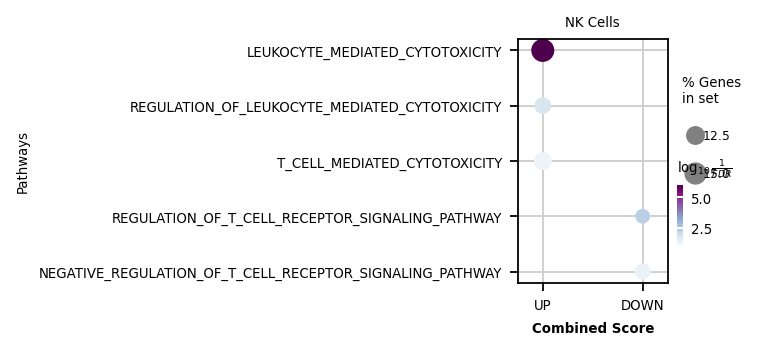

In [57]:
# display multi-dataset
ax = gp.dotplot(enr_res,figsize=(1.5,2),
                x='UP_DW',
                x_order = ["UP","DOWN"],
                title="GO_BP",
                cmap = 'BuPu',
                size=10,
                show_ring=False,vmin=0)

ax.set_title("NK Cells", fontsize=6)

ax.set_xlabel("Combined Score", fontsize=6)  
ax.set_ylabel("Pathways", fontsize=6)    

ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig('Final_Notebooks/Figures/Drug_DGE/PHA_dot_plot_comb_NK.pdf', bbox_inches='tight',dpi=300)
plt.show()

/tmp/ipykernel_3861101/1219592718.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


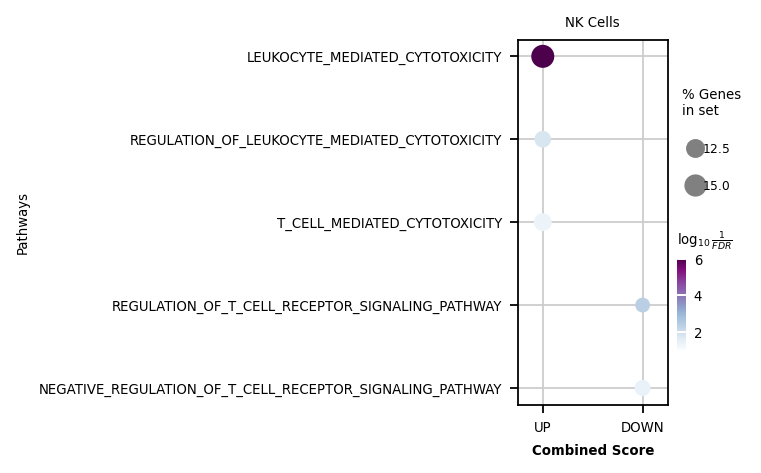

In [58]:
# display multi-dataset
ax = gp.dotplot(enr_res,figsize=(1.5,3),
                x='UP_DW',
                x_order = ["UP","DOWN"],
                title="GO_BP",
                cmap = 'BuPu',
                size=10,
                show_ring=False,vmin=0)

ax.set_title("NK Cells", fontsize=6)

ax.set_xlabel("Combined Score", fontsize=6)  
ax.set_ylabel("Pathways", fontsize=6)    

ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig('Final_Notebooks/Figures/Drug_DGE/PHA_dot_plot_comb_NK_scale.pdf', bbox_inches='tight',dpi=300)
plt.show()

## Perform GO term analysis on DGE by celltype analysis of unstimulated drug vs control

### For BTP2 ###

In [59]:
# Generate file in the Drug comparison Notebook
filename = f"Final_Notebooks/Figures/Drug_comparison/significant_genes_BTP2_vs_Control.csv"
significant_genes = pd.read_csv(filename)

degs_up = significant_genes[significant_genes['Regulation']=='upregulated']
degs_dw = significant_genes[significant_genes['Regulation']=='downregulated']

# Enricr API
enr_up = gp.enrichr(degs_up["names"],
                    gene_sets="Final_Notebooks/GSEA_files/c5.all.v2023.2.Hs.symbols.gmt",
                    organism='human',
                    outdir=None)

enr_up.res2d['Term'] = enr_up.res2d['Term'].apply(lambda x: '_'.join(x.split('_')[1:]) if len(x.split('_')) > 1 else None)


enr_up.res2d = enr_up.res2d[enr_up.res2d["Adjusted P-value"]<0.05]

enr_up.res2d = enr_up.res2d[enr_up.res2d['Term'].str.contains(r'TOLERANCE_|CYTOTOX|REGULAT', na=False)]


enr_up.res2d = enr_up.res2d.sort_values(by='Adjusted P-value', ascending=True)
enr_up.res2d

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
516,c5.all.v2023.2.Hs.symbols.gmt,NEGATIVE_REGULATION_OF_VIRAL_PROCESS,23/93,6.443859e-38,4.895185e-35,148.210728,12692.041399,BST2;APOBEC3A;ISG15;MX1;IFITM1;IFITM2;IFIT5;OA...
1022,c5.all.v2023.2.Hs.symbols.gmt,REGULATION_OF_VIRAL_PROCESS,25/168,3.016629e-35,9.821283e-33,82.506486,6558.138435,BST2;APOBEC3A;ISG15;MX1;IFITM1;IFITM2;IFIT5;OA...
514,c5.all.v2023.2.Hs.symbols.gmt,NEGATIVE_REGULATION_OF_VIRAL_GENOME_REPLICATION,19/55,1.730643e-34,4.930170e-32,217.921990,16941.124729,BST2;APOBEC3A;ISG15;MX1;IFITM1;IFITM2;IFIT5;OA...
1020,c5.all.v2023.2.Hs.symbols.gmt,REGULATION_OF_VIRAL_GENOME_REPLICATION,19/85,2.449029e-30,5.073942e-28,119.426118,8142.695009,BST2;APOBEC3A;ISG15;MX1;IFITM1;IFITM2;IFIT5;OA...
980,c5.all.v2023.2.Hs.symbols.gmt,REGULATION_OF_RESPONSE_TO_BIOTIC_STIMULUS,21/515,1.456969e-17,1.953195e-15,18.076923,700.798714,HERC5;IRF7;ISG15;DTX3L;OASL;DDX60;PARP9;PARP14...
...,...,...,...,...,...,...,...,...
986,c5.all.v2023.2.Hs.symbols.gmt,REGULATION_OF_RIG_I_SIGNALING_PATHWAY,2/20,2.065753e-03,3.487297e-02,40.631678,251.195621,OASL;DDX60
907,c5.all.v2023.2.Hs.symbols.gmt,REGULATION_OF_LEUKOCYTE_PROLIFERATION,5/267,2.108368e-03,3.533066e-02,6.524026,40.200015,BST2;MNDA;LGALS9;CD38;TNFSF13B
634,c5.all.v2023.2.Hs.symbols.gmt,POSITIVE_REGULATION_OF_GENE_EXPRESSION,11/1200,2.181822e-03,3.629469e-02,3.174303,19.450842,STAT1;OAS3;IRF7;PLSCR1;OAS1;ISG15;RSAD2;LGALS9...
661,c5.all.v2023.2.Hs.symbols.gmt,POSITIVE_REGULATION_OF_LEUKOCYTE_PROLIFERATION,4/166,2.432117e-03,3.931061e-02,8.529009,51.336047,CD38;BST2;TNFSF13B;LGALS9


In [60]:
enr_dw = gp.enrichr(degs_dw["names"],
                    gene_sets="Final_Notebooks/GSEA_files/c5.all.v2023.2.Hs.symbols.gmt",
                    organism='human',
                    outdir=None)

enr_dw.res2d['Term'] = enr_dw.res2d['Term'].apply(lambda x: '_'.join(x.split('_')[1:]) if len(x.split('_')) > 1 else None)


enr_dw.res2d = enr_dw.res2d[enr_dw.res2d["Adjusted P-value"]<0.05]

enr_dw.res2d = enr_dw.res2d[enr_dw.res2d['Term'].str.contains(r'_TOLERANCE_|REGULAT|CYTOTOX', na=False)]

enr_dw.res2d = enr_dw.res2d.sort_values(by='Adjusted P-value', ascending=True)
enr_dw.res2d.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
573,c5.all.v2023.2.Hs.symbols.gmt,REGULATION_OF_INFLAMMATORY_RESPONSE,4/428,0.000099,0.013743,23.747454,218.972615,SLAMF8;NT5E;ALOX5AP;IL2RA
357,c5.all.v2023.2.Hs.symbols.gmt,NEGATIVE_REGULATION_OF_RESPONSE_TO_EXTERNAL_ST...,4/483,0.000158,0.014305,20.962829,183.509144,SLAMF8;NT5E;SPP1;IL2RA
525,c5.all.v2023.2.Hs.symbols.gmt,REGULATION_OF_B_CELL_DIFFERENTIATION,2/33,0.000182,0.014492,146.897203,1265.173109,SLAMF8;INHBA
300,c5.all.v2023.2.Hs.symbols.gmt,NEGATIVE_REGULATION_OF_CELL_GROWTH,3/189,0.000185,0.014492,38.085650,327.250081,SPP1;FBP1;INHBA
585,c5.all.v2023.2.Hs.symbols.gmt,REGULATION_OF_LYMPHOCYTE_DIFFERENTIATION,3/212,0.000260,0.014782,33.863962,279.520734,SLAMF8;INHBA;IL2RA


In [61]:
# concat results
enr_up.res2d['UP_DW'] = "UP"
enr_dw.res2d['UP_DW'] = "DOWN"
enr_res = pd.concat([enr_up.res2d.head(10), enr_dw.res2d.head(10)])

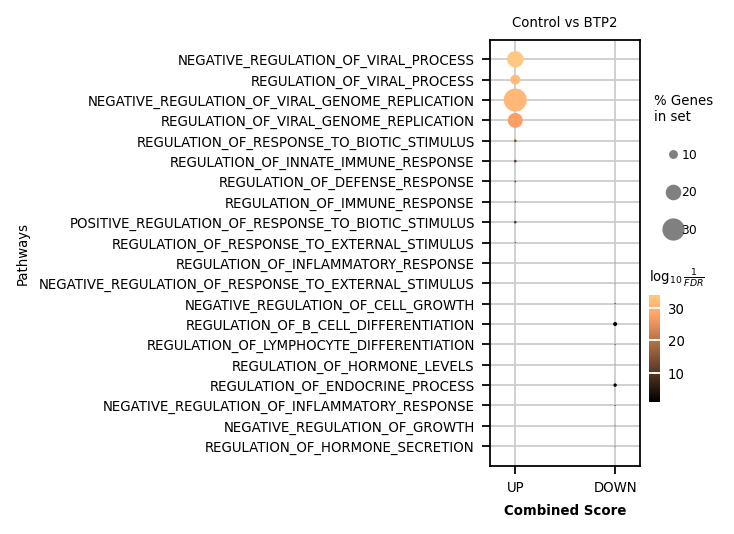

In [62]:
# display multi-dataset
ax = gp.dotplot(enr_res,figsize=(1.5,3.5),
                x='UP_DW',
                x_order = ["UP","DOWN"],
                title="GO_BP",
                cmap = 'copper',
                size=5,cutoff=0.05,
                show_ring=False,vmin=0)

ax.set_title("Control vs BTP2", fontsize=6)

ax.set_xlabel("Combined Score", fontsize=6)  
ax.set_ylabel("Pathways", fontsize=6)    

ax.tick_params(axis='both', which='major', labelsize=6)

#plt.savefig('Final_Notebooks/Figures/Drug_DGE/BTP2_dot_plot_comb.pdf', bbox_inches='tight',dpi=300)
plt.show()

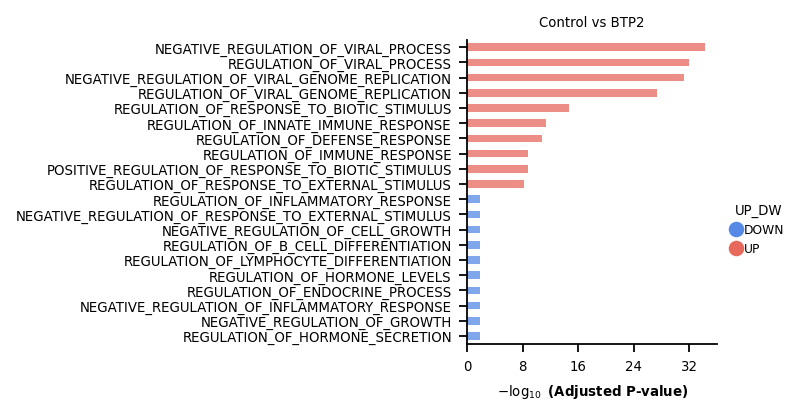

In [63]:
ax = gp.barplot(enr_res, figsize=(2, 2.5), group='UP_DW', title="GO_BP", color=['#5688E6', '#E6695C'])
ax.set_title("Control vs BTP2", fontsize=6)               
ax.set_xlabel(ax.get_xlabel(), fontsize=6)      
ax.set_ylabel(ax.get_ylabel(), fontsize=6)     

ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)
ax.grid(visible=False)

plt.savefig('Final_Notebooks/Figures/Drug_DGE/BTP2_bar_plot_comb.pdf', bbox_inches='tight',dpi=300)
plt.show()

### For CM4620 ###

In [64]:
# Generate file in the Drug comparison Notebook
filename = f"Final_Notebooks/Figures/Drug_comparison/significant_genes_CM4620_vs_Control.csv"
significant_genes = pd.read_csv(filename)

degs_up = significant_genes[significant_genes['Regulation']=='upregulated']
degs_dw = significant_genes[significant_genes['Regulation']=='downregulated']

# Enricr API
enr_up = gp.enrichr(degs_up["names"],
                    gene_sets="Final_Notebooks/GSEA_files/c5.all.v2023.2.Hs.symbols.gmt",
                    organism='human',
                    outdir=None)

enr_up.res2d['Term'] = enr_up.res2d['Term'].apply(lambda x: '_'.join(x.split('_')[1:]) if len(x.split('_')) > 1 else None)


enr_up.res2d = enr_up.res2d[enr_up.res2d["Adjusted P-value"]<0.05]

enr_up.res2d = enr_up.res2d[enr_up.res2d['Term'].str.contains(r'_TOLERANCE_|CYTOTOX|REGULAT', na=False)]


enr_up.res2d = enr_up.res2d.sort_values(by='Adjusted P-value', ascending=True)
enr_up.res2d.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
1295,c5.all.v2023.2.Hs.symbols.gmt,REGULATION_OF_VIRAL_PROCESS,28/168,4.373070e-36,1.787336e-33,59.598299,4852.350383,BST2;APOBEC3A;ISG15;MX1;IFITM1;IFITM2;IFIT5;OA...
654,c5.all.v2023.2.Hs.symbols.gmt,NEGATIVE_REGULATION_OF_VIRAL_PROCESS,24/93,6.644111e-36,2.376100e-33,97.972103,7935.674930,BST2;APOBEC3A;ISG15;MX1;IFITM1;IFITM2;IFIT5;OA...
652,c5.all.v2023.2.Hs.symbols.gmt,NEGATIVE_REGULATION_OF_VIRAL_GENOME_REPLICATION,20/55,1.886255e-33,5.996195e-31,152.022516,11455.005226,BST2;APOBEC3A;ISG15;MX1;IFITM1;IFITM2;IFIT5;OA...
1293,c5.all.v2023.2.Hs.symbols.gmt,REGULATION_OF_VIRAL_GENOME_REPLICATION,20/85,4.708606e-29,1.224666e-26,82.266137,5365.856152,BST2;APOBEC3A;ISG15;MX1;IFITM1;IFITM2;IFIT5;OA...
1244,c5.all.v2023.2.Hs.symbols.gmt,REGULATION_OF_RESPONSE_TO_BIOTIC_STIMULUS,27/515,4.969591e-21,8.363529e-19,15.996606,747.856526,HERC5;ZBP1;IRF7;NMI;ISG15;DTX3L;OASL;DDX60;PAR...


In [65]:
enr_dw = gp.enrichr(degs_dw["names"],
                    gene_sets="Final_Notebooks/GSEA_files/c5.all.v2023.2.Hs.symbols.gmt",
                    organism='human',
                    outdir=None)

enr_dw.res2d['Term'] = enr_dw.res2d['Term'].apply(lambda x: '_'.join(x.split('_')[1:]) if len(x.split('_')) > 1 else None)


enr_dw.res2d = enr_dw.res2d[enr_dw.res2d["Adjusted P-value"]<0.05]

enr_dw.res2d = enr_dw.res2d[enr_dw.res2d['Term'].str.contains(r'_TOLERANCE_|REGULAT|CYTOTOX', na=False)]

enr_dw.res2d = enr_dw.res2d.sort_values(by='Adjusted P-value', ascending=True)
enr_dw.res2d.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
946,c5.all.v2023.2.Hs.symbols.gmt,REGULATION_OF_CELL_DIFFERENTIATION,12/1628,0.000002,0.006196,7.453332,96.694800,SEMA6B;BHLHE41;IL2RA;ABCG1;INHBA;GPR68;HMG20B;...
505,c5.all.v2023.2.Hs.symbols.gmt,NEGATIVE_REGULATION_OF_CELL_POPULATION_PROLIFE...,8/957,0.000073,0.046762,7.360002,70.064835,SEMA6B;IL24;IL2RA;INHBA;CYP1B1;RGCC;LMNA;CD109
549,c5.all.v2023.2.Hs.symbols.gmt,NEGATIVE_REGULATION_OF_LOCOMOTION,5/423,0.000430,0.046762,9.807412,76.034331,SEMA6B;IL24;CYP1B1;SLAMF8;RGCC
596,c5.all.v2023.2.Hs.symbols.gmt,NEGATIVE_REGULATION_OF_RESPONSE_TO_STIMULUS,10/1755,0.000192,0.046762,5.194577,44.466679,SEMA6B;RASAL1;FBP1;IL2RA;DUSP4;SLAMF8;INSIG1;N...
1045,c5.all.v2023.2.Hs.symbols.gmt,REGULATION_OF_MULTICELLULAR_ORGANISMAL_DEVELOP...,9/1484,0.000278,0.046762,5.382133,44.070365,SEMA6B;CYP1B1;BHLHE41;IL2RA;INHBA;GPR68;SLAMF8...


In [66]:
# concat results
enr_up.res2d['UP_DW'] = "UP"
enr_dw.res2d['UP_DW'] = "DOWN"
enr_res = pd.concat([enr_up.res2d.head(10), enr_dw.res2d.head(10)])

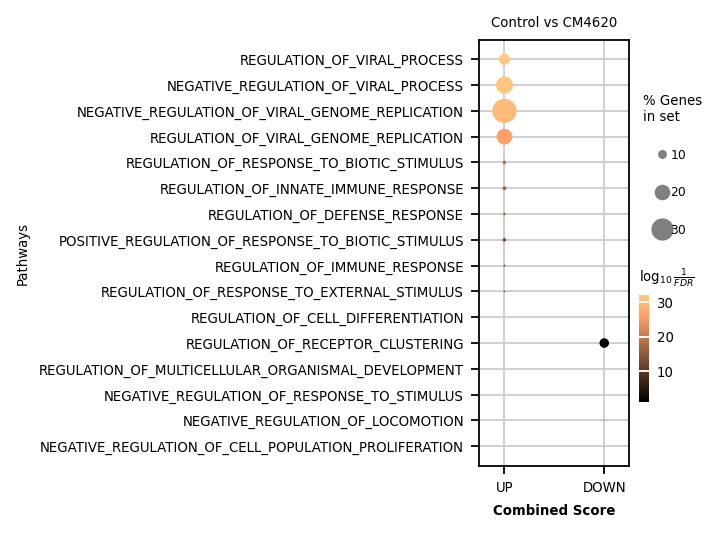

In [67]:
# display multi-dataset
ax = gp.dotplot(enr_res,figsize=(1.5,3.5),
                x='UP_DW',
                x_order = ["UP","DOWN"],
                title="GO_BP",
                cmap = 'copper',
                size=5,cutoff=0.05,
                show_ring=False,vmin=0)

ax.set_title("Control vs CM4620", fontsize=6)

ax.set_xlabel("Combined Score", fontsize=6)  
ax.set_ylabel("Pathways", fontsize=6)    

ax.tick_params(axis='both', which='major', labelsize=6)

#plt.savefig('Final_Notebooks/Figures/Drug_DGE/CM4620_dot_plot_comb.pdf', bbox_inches='tight',dpi=300)
plt.show()

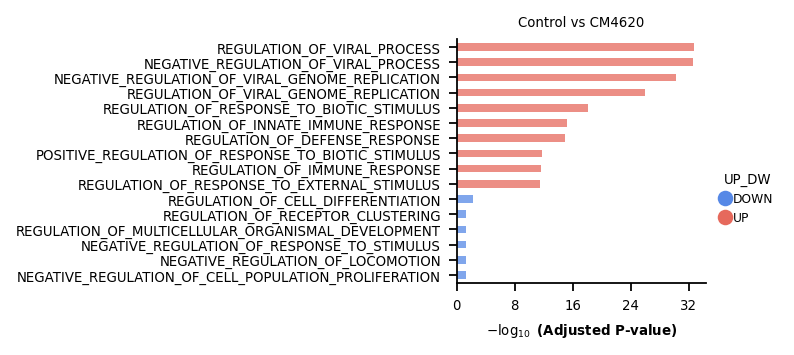

In [68]:
ax = gp.barplot(enr_res, figsize=(2, 2), group='UP_DW', title="GO_BP", color=['#5688E6', '#E6695C'])
ax.set_title("Control vs CM4620", fontsize=6)               
ax.set_xlabel(ax.get_xlabel(), fontsize=6)      
ax.set_ylabel(ax.get_ylabel(), fontsize=6)     

ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)
ax.grid(visible=False)

plt.savefig('Final_Notebooks/Figures/Drug_DGE/CM4620_bar_plot_comb.pdf', bbox_inches='tight',dpi=300)
plt.show()

In [69]:
!pip list

Package                   Version
------------------------- --------------
adjustText                1.3.0
anndata                   0.10.9
anyio                     4.6.2.post1
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
array_api_compat          1.9.1
arrow                     1.3.0
asttokens                 2.4.1
async-lru                 2.0.4
attrs                     24.2.0
babel                     2.16.0
beautifulsoup4            4.12.3
bleach                    6.2.0
Brotli                    1.1.0
cached-property           1.5.2
certifi                   2024.8.30
cffi                      1.17.1
charset-normalizer        3.4.0
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.3.0
cycler                    0.12.1
debugpy                   1.8.8
decorator                 5.1.1
defusedxml                0.7.1
entrypoints               0.4
et_xmlfile                2.0.0
exceptiongroup            1.2.2
executing    